<a href="https://colab.research.google.com/github/photon1976/Mask_RCNN/blob/master/Z_TECS_Cattle_Segment_Mask_R_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p><img alt="Colaboratory logo" height="45px" src="/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px"></p>

<h1>Segmentação Usando Mask R-CNN</h1>

O modelo `Mask R-CNN` lida com um dos maiores desafios da visão computacional: segmentação de imagens. A segmentação é uma tarefa que consiste em detectar e distinguir múltiplos objetos dentro uma mesma imagem. Particularmente, `Mask R-CNN` executa a "segmentação de instância", isto é, reconhece diferentes instâncias do mesmo objeto na imagem de entrada. Por exemplo, `pessoa`  poderia ser associado a diferentes rótulos na mesma imagem. 

## **Verificação das Configurações do Ambiente**

Primeiramente a disponibilidade do ``TensorFlow`` usando gpu e qual é a versão. tenção para o uso do caractere ! indicando que a linha será executada pela shell do sistema subjacente. 

**IMPORTANTE**:  Tive problemas com a versão do TensorFlow carregada no ambiente. Por isso desabilitei a verificação via `import`.


In [5]:
# import tensorflow as tf

# print('versão TensorFlow:{:} gpu em uso:{:}'.format(tf.__version__,
#                                                    tf.test.gpu_device_name()))
# import sys
# del sys.modules["tensorflow"]

!pip show tensorflow

Name: tensorflow
Version: 2.2.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: six, tensorflow-estimator, termcolor, gast, grpcio, opt-einsum, protobuf, wrapt, wheel, google-pasta, scipy, tensorboard, astunparse, numpy, absl-py, keras-preprocessing, h5py
Required-by: fancyimpute


Temos `TensorFlow` na versão `2.2.0` que pode não ser compatível com implementação `Mask R-CNN` que iremos utilizar.




Verificando qual é a gpu e qual é a versão de [``CUDA``](https://developer.nvidia.com/cuda-zone).

In [6]:
!/opt/bin/nvidia-smi
!nvcc --version

Tue May 19 18:41:44 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

Finalmente, vamos verificar a versão GNU/Linux.

In [0]:
!uname -a
!cat /etc/lsb-release

Linux c342b6efad7b 4.19.104+ #1 SMP Wed Feb 19 05:26:34 PST 2020 x86_64 x86_64 x86_64 GNU/Linux
DISTRIB_ID=Ubuntu
DISTRIB_RELEASE=18.04
DISTRIB_CODENAME=bionic
DISTRIB_DESCRIPTION="Ubuntu 18.04.3 LTS"


## **Instalação da Mask R-CNN**

Vamos usar uma implementação de Mask R-CNN em Keras. Aqui estamos usando a implementação da [Matterport](http://matterport.com) disponível no [GitHub](https://github.com/matterport/Mask_RCNN). 
Atenção para o uso dos caracteres `%%` indicando que uma sequência de comandos na célula serão executados pelo sistema subjacente, que é o caso aqui. Primeiramente estamos garantindo as versões do `TensorFlow` e `Keras` requeridas pela implementação. Depois clonamos diretamente do repositório e executamos o script de instalação.


In [7]:
%%shell
pip install tensorflow==1.9.0
pip install keras==2.2.0
# clone Mask_RCNN repo and install packages
git clone https://github.com/matterport/Mask_RCNN
cd Mask_RCNN
python setup.py install 

     |████████████████████████████████| 51.1MB 64kB/s 
     |████████████████████████████████| 573kB 50.4MB/s 
     |████████████████████████████████| 3.3MB 52.9MB/s 
ERROR: xarray 0.15.1 has requirement setuptools>=41.2, but you'll have setuptools 39.1.0 which is incompatible.
ERROR: google-auth 1.7.2 has requirement setuptools>=40.3.0, but you'll have setuptools 39.1.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: setuptools 46.3.0
    Uninstalling setuptools-46.3.0:
      Successfully uninstalled setuptools-46.3.0
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installation: tensorflow 2.2.0
    Uninstalling tensorflow-2.2.0:
      Successfully uninstalled tensorflow-2.2.0
     |████████████████████████████████| 307kB 4.9MB/s 
     |████████████████████████████████| 

Depois de instalada a implementação da `Mask R-CNN` precisamos garantir que o script execute no contexto do diretório `Mask_RCNN` que contém a implementação. A instrução python `sys.path.append(ROOT_DIR)` garante isso. Vamos importar as bibliotecas, classes e fazer o download do modelo R-CNN pré-treinado. Estou ignorando *warnings* de importação do `TensorFlow`, principalmente, *FutureWarning*.

In [8]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior() 

import warnings
warnings.filterwarnings("ignore")

# Root directory of the project
ROOT_DIR = os.path.abspath("./Mask_RCNN/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize

# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

Using TensorFlow backend.


... done downloading pretrained model!


Classe de configuração para criar o modelo. Na sequência já instanciamos um objeto `config` que será usado na criação do modelo.

In [0]:
class InferenceConfig(coco.CocoConfig):
    # give the configuration a recognizable name
    NAME = "coco_inference"
    
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # number of classes (we would normally add +1 for the background
    # but the background class is *already* included in the class names)
    # NUM_CLASSES = NUM_CLASSES
#  -----------------------------------------------------------------------------

config = InferenceConfig()

Se quisermos podemos consultar as configurações que serão passadas na criação do modelo

In [10]:
config.display()



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

Criação efetiva do modelo.

In [0]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)



Agora vamos carregar para nosso modelo os pesos do modelo pré-treinado com a `MS-COCO`. Os pesos estão no arquivo `h5` baixado anteriormente. 

In [0]:
# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

Montar uma pasta do Google Drive que contém nossa base de imagens.

In [13]:
# Mounting the Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [14]:
base_dir = '/content/gdrive/My Drive/Colab Notebooks/imgs'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
test_fnames = os.listdir(test_dir)

# showing the full path
print(train_dir)
print(test_dir)

/content/gdrive/My Drive/Colab Notebooks/imgs/train
/content/gdrive/My Drive/Colab Notebooks/imgs/test


In [0]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']





# Load a random image from the images folder
# file_names = next(os.walk(IMAGE_DIR))[2]
# image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
# results = model.detect([image], verbose=1)

# Visualize results
# r = results[0]
# visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
#                            class_names, r['scores'])

Testando em uma imagem, a primeira do diretório.

Processing 1 images
image                    shape: (547, 799, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  143.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


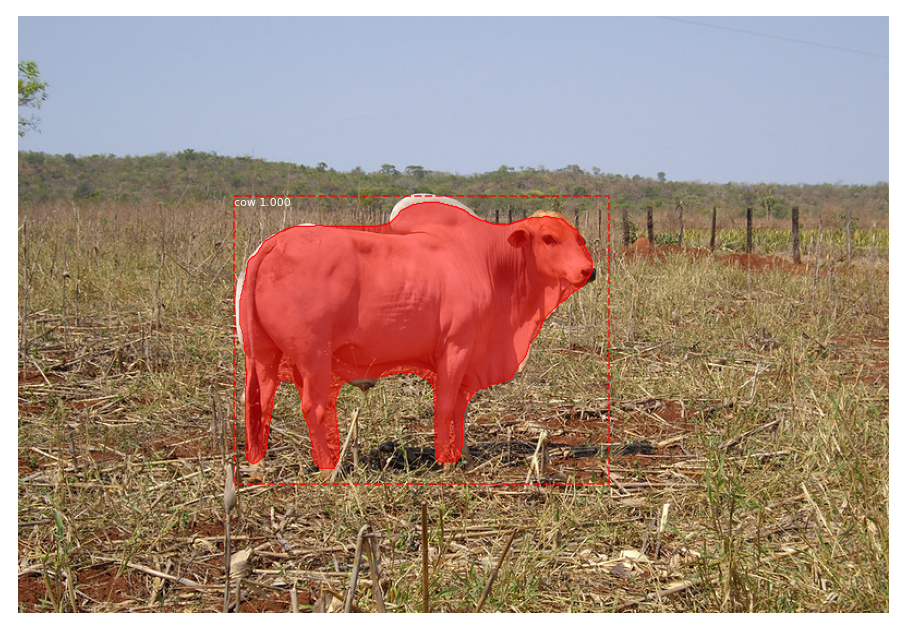

In [18]:
image_test1 = skimage.io.imread(test_dir + '/' + test_fnames[0])

# Run detection
results = model.detect([image_test1], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image_test1, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

Aplicando a segmentação automática.

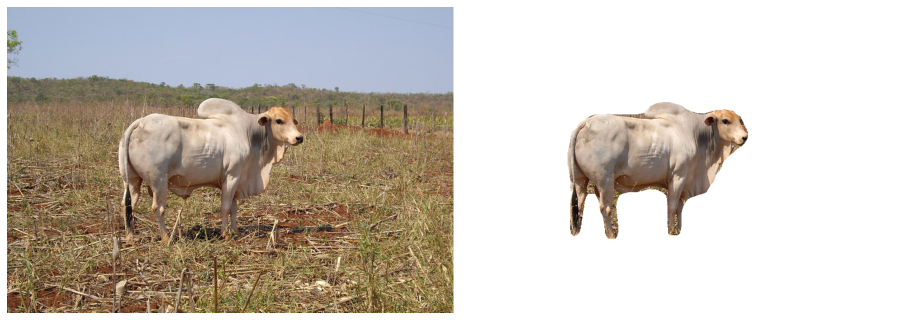

In [20]:
# -----------------------------------------------------------------------------
def segment(image, r):
  idx = r['scores'].argmax()
  mask = r['masks'][:,:,idx]
  mask = np.stack((mask,)*3, axis=-1)
  mask = mask.astype('uint8')
  bg = 255 - mask * 255
  mask_img = image*mask
  result = mask_img+ bg
  return result
# -----------------------------------------------------------------------------


segmentation = segment(image_test1, r)
plt.subplots(1, figsize=(16, 16))
plt.axis('off')
plt.imshow(np.concatenate([image_test1, segmentation], axis = 1))

Usando agora todas as imagens do diretório.

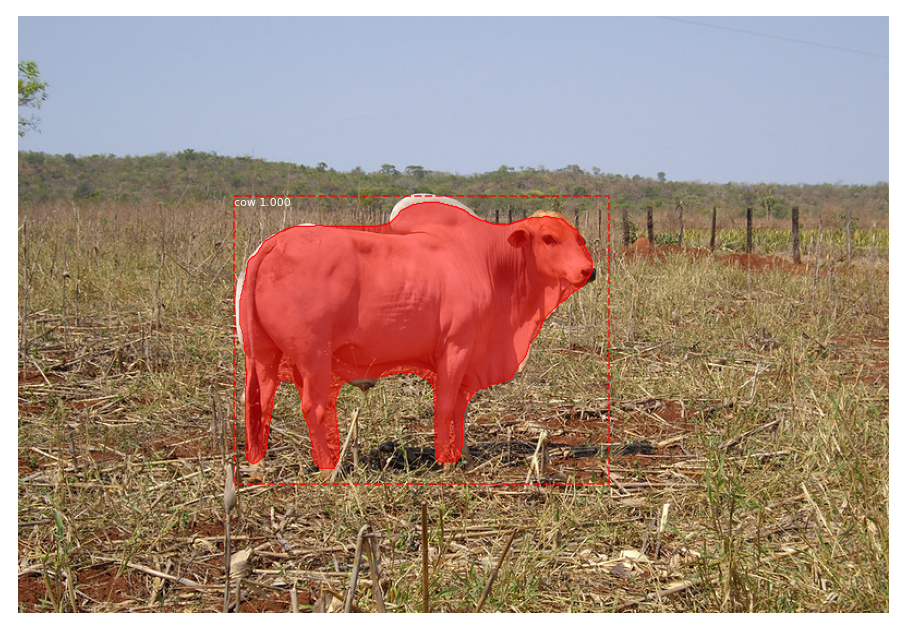

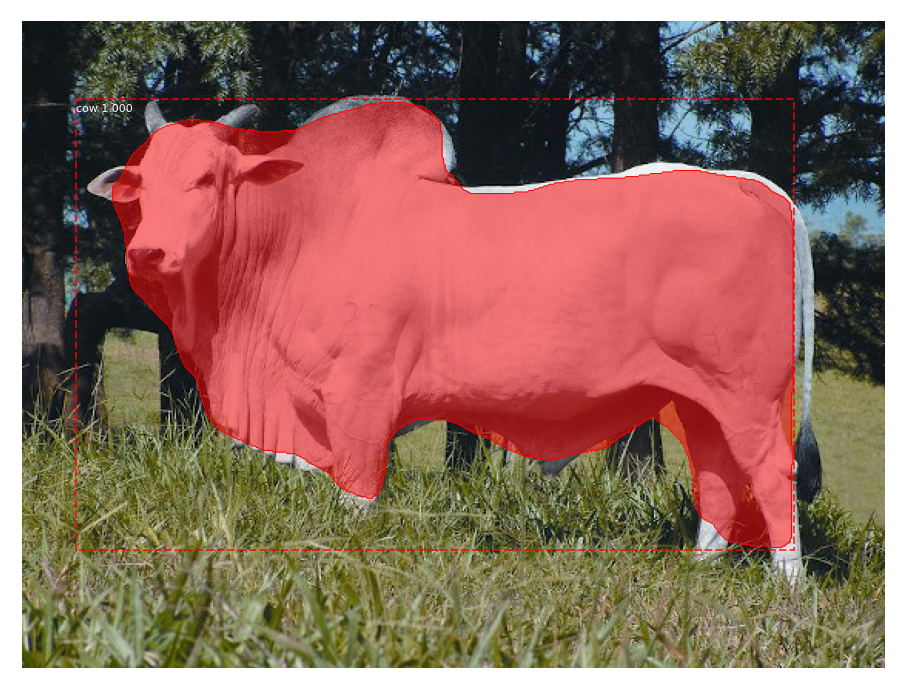

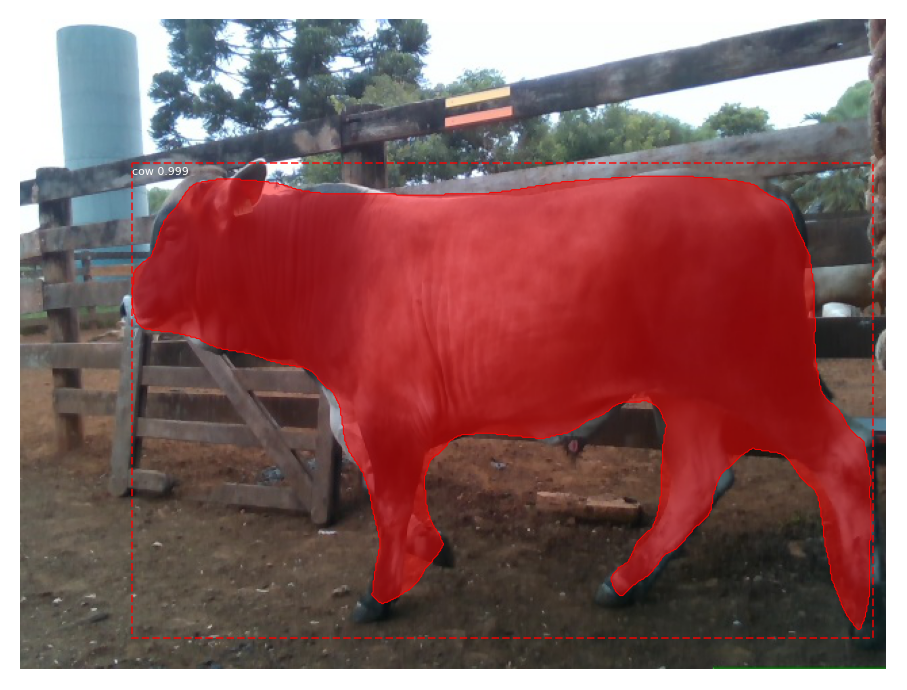

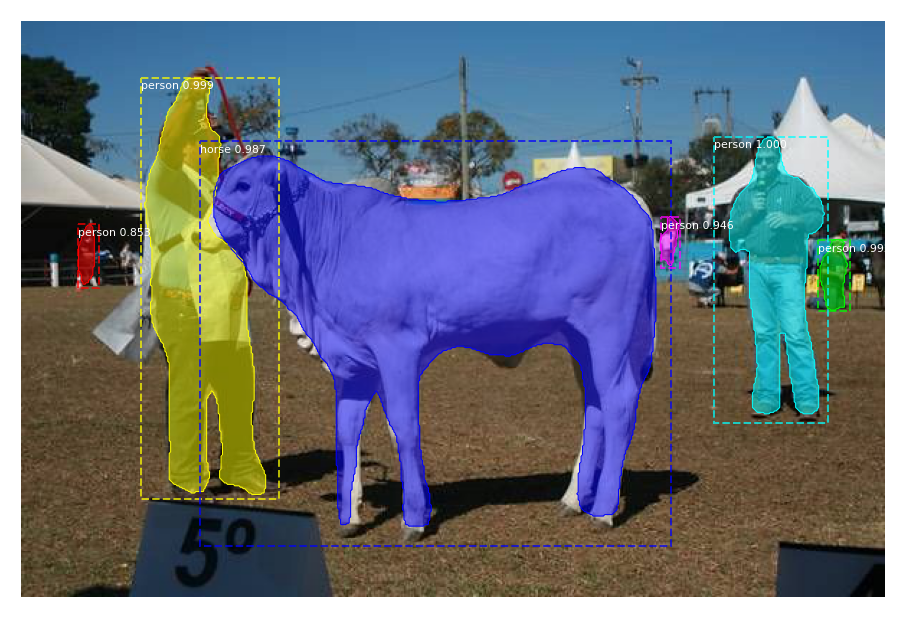

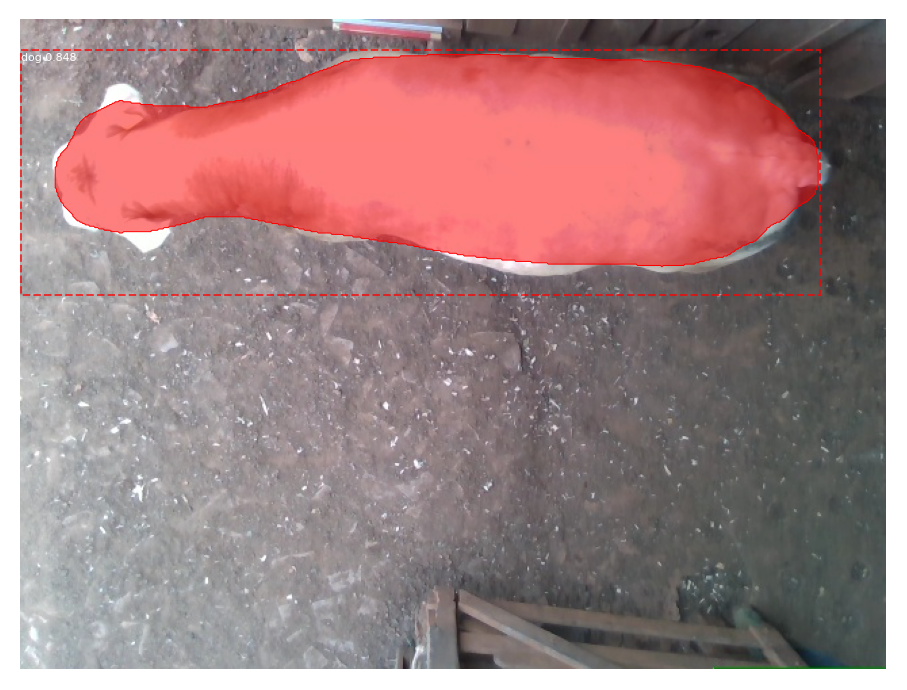

In [21]:
for test_fname in test_fnames:
  image = skimage.io.imread(test_dir + '/' + test_fname)
  # Run detection
  results = model.detect([image], verbose=0)

  # Visualize results
  r = results[0]
  visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                              class_names, r['scores'])